In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping
from keras.layers.merge import concatenate

from math import ceil

import seaborn as sns
sns.set()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [294]:
input_dataset_path = 'drive/MyDrive/Collab-Datasets/nasd_input.csv'
query_dataset_path = 'drive/MyDrive/Collab-Datasets/nasd_query.csv'
DATASET_SIZE = 10
LOOKBACK = 15

In [295]:
timeseries_df = pd.read_csv(input_dataset_path, sep='\t', index_col=0, header=None).astype(np.float32).sample(DATASET_SIZE)
TIME_SERIES_ID = timeseries_df.index.tolist()

In [403]:
def normalize(X, _max, _min):
  return (X - _min)/(_max-_min) 

def reverse_normalize(X, _max, _min):
  return X*(_max-_min) + _min 

def preprocess_timeseries(_timeseries, window=10, normalized=False, _max = None, _min = None):
  if not normalized:
    if _max is None:
      _max = _timeseries.min()
    if _min is None:
      _min = _timeseries.max()

    timeseries = normalize(_timeseries, _max, _min)
  else:
    timeseries = _timeseries
  
  X = None
  for i in range(window, len(timeseries)):
    X_i = np.asarray(timeseries[i-window:i]).reshape((1, len(timeseries[i-window:i]), 1))
    X = np.concatenate((X, X_i)) if X is not None else X_i
    
  return X, X, _max, _min

In [404]:
window_length = 10
X_all, _max, _min = preprocess_timeseries(timeseries_df.to_numpy()[0], window_length)
X_train, X_test = train_test_split(X_all, test_size=0.33, shuffle=False)

ValueError: ignored

In [482]:
class TimeSeriesComplexityReducerModel():
  n_conv_filt_default = 10
  def __init__(self, window_size, conv_layers_setting=[], latent_dim=3, pool_size=2, _optimizer='adam', _loss='mse', dropout_rate=None, verbose=False):
    self.verbose=verbose
    self.input_dim = window_size
    self.latent_dim = latent_dim 
    self.pool_size = pool_size
    
    self.history = None
    self.D_train = None
    self.D_test = None
    self.dropout = dropout_rate
    self.optimizer = _optimizer
    self.loss = _loss

    # init input layer
    input_w = layers.Input(shape=(window_size,1))
    input_dim = window_size
    x = input_w

    # add the convolution layers
    for conv_settings in conv_layers_setting:
      # set up convolution filters and kernel dimensions 
      filters = self.n_conv_filt_default
      if 'filters' in conv_settings:
        filters = conv_settings['filters']
      kernel_size = conv_settings['kernel_size']

      # add the layer into the encoder
      x = layers.Conv1D(filters, kernel_size, padding="same", activation="relu")(x)
      
      # downsample if you can
      if ceil(input_dim/pool_size) > latent_dim:
        input_dim = ceil(input_dim/pool_size)
        x = layers.MaxPooling1D(pool_size, padding="same")(x)

      if self.dropout is not None:
        x = layers.Dropout(self.dropout)(x)

    # final compression
    x = layers.Flatten()(x)
    x = layers.Dense(latent_dim, activation='relu')(x)
    encoded = layers.Reshape((latent_dim, 1))(x)
    
    self.encoder = models.Model(input_w, encoded, name='encoder')
    if self.verbose:
      self.encoder.summary()    


    # decoder model
    output_dim = latent_dim 

    x = layers.Conv1DTranspose(1, latent_dim, activation='relu', padding="same")(encoded)
    # up sampling
    if output_dim*pool_size <= window_size:
        output_dim = output_dim*pool_size
        x = layers.UpSampling1D(pool_size)(x)
    
    # add dropout
    if self.dropout is not None:
      x = layers.Dropout(self.dropout)(x)

    # for all conv layers provided add a reconstructor layer of the input timeseries
    for i, conv_settings in enumerate(conv_layers_setting[::-1]):
      padding="same"
      filters = self.n_conv_filt_default
      if 'filters' in conv_settings:
        filters = conv_settings['filters']
      kernel_size = conv_settings['kernel_size']

      x = layers.Conv1DTranspose(filters, kernel_size, activation="relu", padding=padding)(x)
      
      if output_dim*pool_size <= window_size:
        output_dim = output_dim*pool_size
        x = layers.UpSampling1D(pool_size)(x)
      
      if self.dropout is not None:
        x = layers.Dropout(self.dropout)(x)

    # decoded = layers.Conv1DTranspose(1, window_size-output_dim+1, activation="sigmoid")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(window_size, activation='sigmoid')(x)
    decoded = layers.Reshape((window_size, 1))(x)

    self.autoencoder = models.Model(input_w, decoded, name="autoencoder")
    if self.verbose:
      self.autoencoder.summary()
    
    self.autoencoder.compile(optimizer='adam', loss='mse')


  def fit(self, X, y, epochs=50, batch_size=128):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    self.D_train = X_train, y_train
    self.D_test = X_test, y_test
    es = EarlyStopping(monitor="val_loss", mode="min", patience=10, min_delta=1e-4)
    self.history = self.autoencoder.fit(
      X_train,
      y_train,
      validation_data=(X_test, y_test),
      epochs=epochs,
      batch_size=batch_size,
      verbose=1,
      callbacks=[es],
    )
    return self.history

  def predict(self, X):
    return self.autoencoder.predict(X)

  def encode(self, X):
    return self.encoder.predict(X)

  def evaluate(self, X, y_true):
    return self.autoencoder.evaluate(X, y_true, batch_size=64)

In [483]:
autoencoder = TimeSeriesComplexityReducerModel(window_length, [{'filters':64, 'kernel_size':7}, {'filters':64, 'kernel_size':7}], latent_dim=7, pool_size=2)

In [484]:
def plot_examples(stock_input, stock_decoded):
    n = 10  
    plt.figure(figsize=(20, 4))
    y_true = [v[0, 0] for v in stock_input[:]] + stock_input[-1, :, :].reshape(-1).tolist()
    y_pred = [v[0, 0] for v in stock_decoded[:]]+ stock_decoded[-1, :, :].reshape(-1).tolist()
    print(y_true)
    plt.plot(range(len(y_true)), y_true, y_pred)

[451.0, 440.92, 448.11, 451.0, 442.0, 436.65, 471.75, 465.74, 465.3, 356.5, 339.99, 335.99, 336.0, 334.05, 340.0, 310.12, 327.18, 340.87, 328.0, 330.01, 342.85, 312.26, 321.81, 214.28, 205.32, 231.35, 300.01, 269.68, 269.99, 240.11, 223.80998, 239.68001, 220.4, 190.75, 172.01001, 160.0, 156.33002, 168.45001, 170.4, 185.0, 195.28998, 183.51001, 177.0, 173.63, 181.75, 173.53, 187.25, 195.85, 199.5, 203.0, 215.0, 211.98999, 208.0, 188.29999, 177.04999, 193.0, 203.0, 203.65, 203.35999, 195.25, 206.5, 202.0, 203.0, 254.04, 236.43001, 225.99998, 210.07, 212.0, 204.22, 206.0, 202.5, 199.0, 193.54999, 192.08002, 191.0, 187.04999, 185.13, 202.97, 212.0, 232.33, 259.95, 255.04, 247.0, 239.0, 233.74998, 228.0, 236.31, 232.98001, 222.04, 231.95, 227.4, 223.82999, 221.28, 217.98999, 215.84999, 216.78998, 231.55, 224.0, 225.01, 216.5, 220.0, 216.57, 227.34999, 204.65, 197.85, 192.0, 181.85, 182.6, 177.02002, 173.98999, 183.85, 182.0, 185.0, 188.23999, 169.01001, 173.35, 173.06, 170.39001, 167.0, 168

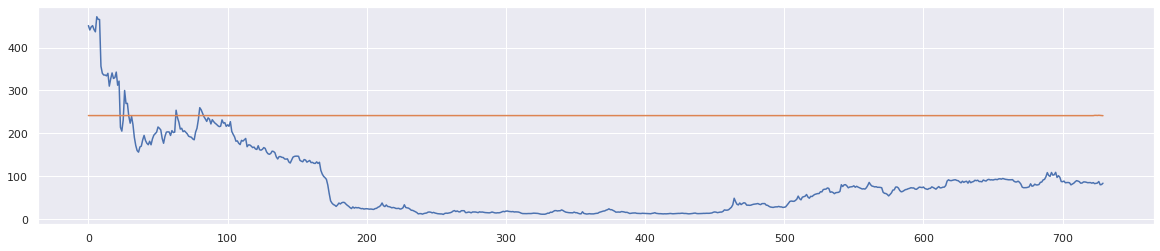

In [485]:
test_samples = 50

plot_examples(reverse_normalize(X_all, _max, _min), reverse_normalize(autoencoder.predict(X_all), _max, _min))

In [621]:
class TimeSeriesComplexityReducer:
  def __init__(self, model, dataset, timeseries_labels=None):
    self.dataset = dataset
    self.model = model
    self.history = []
    self.trained = False
    self.eval_data = []
    self.labels = timeseries_labels if timeseries_labels is not None else list(range(len(dataset)))
    self.max = []
    self.min = []
    self.X_train_all = None
    self.y_train_all = None

  def solve(self, epochs=100, batch_size=128):
    self.trained = True
        
    for timeseries in self.dataset:
      # preprocess timeseries
      X_normalized, y_normalized, _max, _min = preprocess_timeseries(timeseries, self.model.input_dim)
      self.max.append(_max)
      self.min.append(_min)

      # train-test for timeseries
      train_lim = 5*len(X_normalized)//6
      X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, shuffle=False)
            
      self.X_train_all = X_train if self.X_train_all is None else np.concatenate((self.X_train_all, X_train))
      
      self.y_train_all = y_train if self.y_train_all is None else np.concatenate((self.y_train_all, y_train))
      

      # add the eval data in the respective array
      self.eval_data.append((X_test, y_test))
    
    self.history = self.model.fit(self.X_train_all, self.y_train_all, epochs=epochs, batch_size=batch_size)

  
  def plot_graphs(self, timeseries_idx=None):
    if not self.trained:
      raise Exception("Problem not solved")
    if timeseries_idx is None:
      timeseries_idx = range(len(self.labels))

    figure(figsize=(20, 10))
    lgnd = []
    for i in timeseries_idx:
      print(f'Ploting pred for {self.labels[i]}')
      lgnd += [f"{self.labels[i]}-True", f"{self.labels[i]}-Pred"]
      X, y = self.eval_data[i]
      y_pred = self.model.predict(X)

      y = np.concatenate((y[:, 0, 0].reshape(-1),y[-1, :, 0].reshape(-1)))
      y_pred = np.concatenate((y_pred[:, 0, 0].reshape(-1),y_pred[-1, :, 0].reshape(-1)))

      plt.plot(
      range(len(y.reshape(-1))),
      reverse_normalize(y, self.max[i], self.min[i]).reshape(-1),
      "o-",
      )

      plt.plot(
      range(len(y_pred.reshape(-1))),
      reverse_normalize(y_pred, self.max[i], self.min[i]).reshape(-1),
      "o-",
      )
    plt.legend(lgnd)
    plt.show()

  def sample_timeseries(self, _timeseries, window):
    _max = _timeseries.min()
    _min = _timeseries.max()
    timeseries = normalize(_timeseries, _max, _min)
  
    X = None
    for i in range(window, len(timeseries), window):
      X_i = np.asarray(timeseries[i-window:i]).reshape((1, len(timeseries[i-window:i]), 1))
      X = np.concatenate((X, X_i)) if X is not None else X_i
    
    if len(timeseries) % window > 0:
      X_i = np.asarray(timeseries[-1-window:-1]).reshape((1, len(timeseries[-1-window:-1]), 1))
      X = np.concatenate((X, X_i))

    return X, X, _max, _min

  def reduce_and_export(self, timeseries_ndarray, out_filename='test.out'):
    def _reduce(timeseries):
      X, y, _max, _min = self.sample_timeseries(timeseries, self.model.input_dim) 
      return self.model.encode(X).reshape(-1)
    
    return np.apply_along_axis(_reduce, 1, timeseries_ndarray)
    
      

In [622]:
problem=TimeSeriesComplexityReducer(autoencoder, timeseries_df.to_numpy(), TIME_SERIES_ID)

In [623]:
problem.reduce_and_export(timeseries_df.to_numpy()[:1]).shape

(1, 504)